In [69]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import hashlib
import swifter

from tqdm.auto import tqdm

In [70]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

В лекции мы выяснили, что при проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между 0 и 1 группой не только в конкретно нашем АА-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество АA-тестов и посмотреть, в каком количестве случаем нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. Например, если мы принимаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Понятное дело, что на практике провести бесконечное число тестов у нас навряд ли получится, поэтому используется небольшой трюк! Мы будем многократно извлекать подвыборки с повторениями из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

Итак, что нужно сделать: у нас есть данные АА-теста с '2022-05-17' по '2022-05-23'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

In [71]:
query = '''
select exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions 
where toDate(time) between '2022-05-17' and '2022-05-23'
    and exp_group in (2, 3)
group by exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [72]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [73]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


### Построим гистограмму распределения получившихся 10000 p-values

  0%|          | 0/10000 [00:00<?, ?it/s]

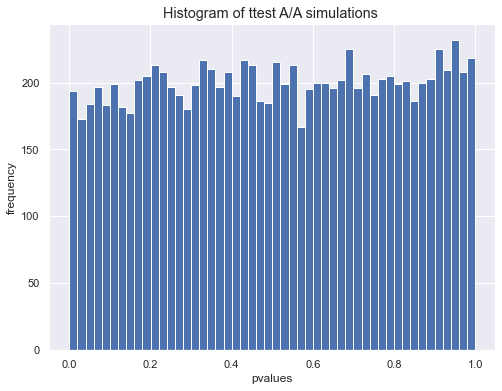

0.0463

In [75]:
simulations = 10000
n_s = 500
res = []

for i in tqdm(range(simulations)):
    s1 = df[df.exp_group == 2].ctr.sample(n_s, replace = False).values
    s2 = df[df.exp_group == 3].ctr.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <= 0.05) / simulations

### Проведем визуальную оценку, а также Т-тест и тест Мана-Уитни для групп 2 и 3

In [77]:
sns.set(rc={'figure.figsize':(12,9)})

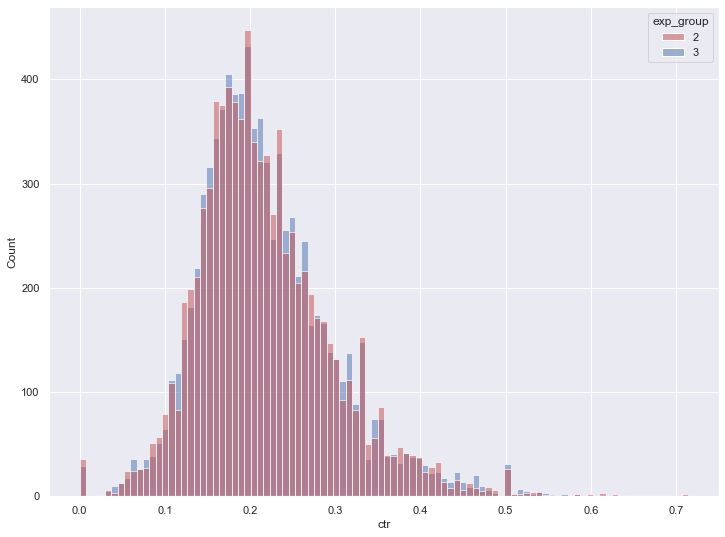

In [78]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [80]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [66]:
print(stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr))

print('Отличие не прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)
Отличие не прокрасилось
В 49.48 % случаев A > B. Должно получиться около 50%


#### Вывод:
- 4.63% pvalues оказался меньше либо равен 0.05
- Мы можем утверждать, что система сплитования работает корректно, поскольку FPR < альфа
- Результаты, полученные при Т-тесте и тесте Мана-Уитни позволяют нам принять нулевую гипотезу о равенстве средних значений ctr в группах 2 и 3